In [25]:
#https://www.kaggle.com/code/nguynkoi/vlai-imgcap2vqa

In [2]:
from PIL import Image
import pandas as pd
import os

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models import resnet34, ResNet34_Weights
import torch.optim as optim

from torchinfo import summary
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer



In [3]:
config = {
    'seed': 59,
    'dataset': 'dataset',
    'val_set_ratio': 0.1,
    'train_batch_size': 16,
    'val_batch_size': 16,
    'max_seq_len': 30,
    'aug_methods': 'imagecaptioning',
    'fusion_strategy': 'concat',
    'imagecaptioning_id': 'vit-gpt2-image-captioning',
    'max_length': 20,
    'min_length': 10,
    'num_beams': 4,
    'aug_strategy': 'sum',
    'activation_F': 'GELU',
    'text_encoder_id': 'bert-base-uncased',
    'img_encoder_id': 'resnet34',
    'joint_embedding_dim': 1024,
    'mlp_input_dim': 2048,
    'mlp_strategy': '2l:(*1_0.5)',
    'mlp_hidden_unit': 1024,
    'learning_rate': 1e-5,
    'weight_decay': 1e-5,
    'epochs': 50,
    'patience': 5,
}

In [4]:
df = pd.read_csv("dataset/data.csv")
df.head()


question           answer image_id
0  what is on the left side of the white oven on ...      garbage_bin   image1
1  what is on the left side of the fire extinguis...            table   image1
2  what is between the the two white and black ga...            chair   image1
3  how many objects are between the fire extingui...                3   image1
4         what is the largest object in this picture  washing_machine   image1

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
df.describe()

question answer image_id
count                  12468  12468    12468
unique                  5886   1443     1447
top     what is on the table      2   image8
freq                     248    554       31

# Image Captioning

In [7]:
IMAGE_PATH_ROOT = "dataset/images"
FOLDER = os.listdir(IMAGE_PATH_ROOT)
DATASET_ROOT_PATH = 'dataset'


In [8]:
FILES = []
for file in FOLDER: 
    FILES.append(f'{IMAGE_PATH_ROOT}/{file}')

In [9]:
imgcap_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.47.1"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

In [10]:
imgcap_model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(i

In [11]:
gen_kwargs = {
    "max_length": config['max_length'],
    "min_length": config['min_length'],
    "num_beams": config['num_beams'],
}

In [12]:
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = imgcap_model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

In [13]:
img_caption = dict()
batchs = []

for i in range(0, len(FILES), 256):
    batchs.append(FILES[i:i+256])
print('Batchs = ', len(batchs))

Batchs =  6


In [14]:
imgcap = []
progress = 0
for batch in batchs: 
    imgcap.append(predict_step(batch))
    progress += 1
    print(f'Progress: {progress}/{len(batchs)}')

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Progress: 1/6
Progress: 2/6
Progress: 3/6
Progress: 4/6
Progress: 5/6
Progress: 6/6


In [15]:
img_cap = [i for batch in imgcap for i in batch]
print(len(img_cap))

print(img_cap[:10])

1449
['a kitchen with a stove, microwave and a refrigerator', 'a kitchen with a stove, refrigerator, and cabinets', 'a display case filled with lots of different types of vases', 'a bedroom with a bed and a desk', 'people sitting in a living room watching tv', 'a bed with a blanket and pillows on top of it', 'a room that has a bunch of stuff on the floor', 'a bedroom with a bed and a dresser', 'a tv sitting on top of a wooden cabinet in a room', 'a bedroom with a bed and a lamp']



 image1:  a kitchen with a stove, microwave and a refrigerator


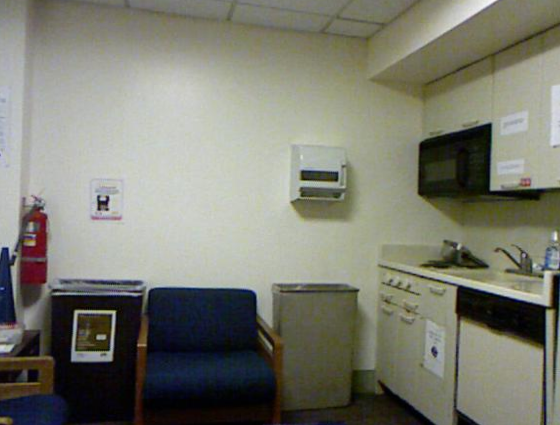


 image10:  a kitchen with a stove, refrigerator, and cabinets


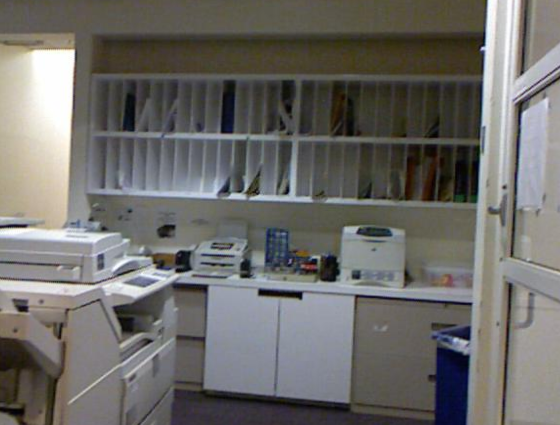


 image100:  a display case filled with lots of different types of vases


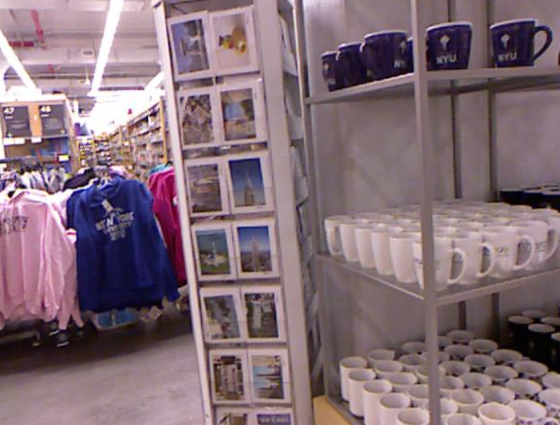

In [16]:
from IPython.display import display

name_file = [i.split('.')[0] for i in FOLDER]
imgcap_dict = dict(zip(name_file, img_cap))

count = 0
for key, item in imgcap_dict.items():
    print(f'\n {key}:  {item}')
    im = Image.open(f'{IMAGE_PATH_ROOT}/{key}.png')
    display(im)  # use IPython.display to show the image in the notebook
    count += 1
    if count == 3: break

In [17]:
vocabulary_ic = set(' '.join(img_cap).replace(',', '').split())
len(vocabulary_ic)

281

# Create Data Sample

In [18]:
def create_data_sample(path, imgcap_dict):
    df = pd.read_csv(path)
    
    questions = df['question'].tolist()
    answers = df['answer'].tolist()
    images = df['image_id'].tolist()

    data_sample = []

    for question, answer, image in zip(questions, answers, images):
        answer_choices = answer.split(', ')
        sample = {
            'question': question,
            'answer': answer_choices[0],
            'image_id': image,
            'ic': imgcap_dict[image]
        }
        data_sample.append(sample)

    return data_sample

In [19]:
all_data = create_data_sample(f'{DATASET_ROOT_PATH}/data.csv', imgcap_dict)


In [20]:
all_data

[{'question': 'what is on the left side of the white oven on the floor and on right side of the blue armchair',
  'answer': 'garbage_bin',
  'image_id': 'image1',
  'ic': 'a kitchen with a stove, microwave and a refrigerator'},
 {'question': 'what is on the left side of the fire extinguisher and on the right side of the chair',
  'answer': 'table',
  'image_id': 'image1',
  'ic': 'a kitchen with a stove, microwave and a refrigerator'},
 {'question': 'what is between the the two white and black garbage bins',
  'answer': 'chair',
  'image_id': 'image1',
  'ic': 'a kitchen with a stove, microwave and a refrigerator'},
 {'question': 'how many objects are between the fire extinguisher and the white oven on the floor',
  'answer': '3',
  'image_id': 'image1',
  'ic': 'a kitchen with a stove, microwave and a refrigerator'},
 {'question': 'what is the largest object in this picture',
  'answer': 'washing_machine',
  'image_id': 'image1',
  'ic': 'a kitchen with a stove, microwave and a refrig

In [21]:
train_data = create_data_sample(f'{DATASET_ROOT_PATH}/data_train.csv', imgcap_dict)
test_data = create_data_sample(f'{DATASET_ROOT_PATH}/data_eval.csv', imgcap_dict)

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

vocab = tokenizer.get_vocab()
vocab_size = len(vocab)

print(f"Vocab size: {vocab_size}")
print(list(vocab.keys())[1000:1050])

Vocab size: 30522
['"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']


In [23]:
def tokenize(question, max_seq_len):
    tokens = tokenizer.encode(
        question,
        add_special_tokens=True,  
        max_length=config['max_seq_len'],
        padding='max_length',     
        truncation=True           
    )
    return tokens

print(tokenize(all_data[0]['question'], max_seq_len=30))

[101, 2054, 2003, 2006, 1996, 2187, 2217, 1997, 1996, 2317, 17428, 2006, 1996, 2723, 1998, 2006, 2157, 2217, 1997, 1996, 2630, 29372, 102, 0, 0, 0, 0, 0, 0, 0]


In [24]:
ANSWER_SPACE_PATH = f'{DATASET_ROOT_PATH}/answer_space.txt'
with open(ANSWER_SPACE_PATH, 'r') as f:
    data = f.read()
    classes = data.split('\n')
    n_classes = len(classes)

    classes_to_idx = {
        cls_name: idx for idx, cls_name in enumerate(classes)
    }

    idx_to_classes = {
        idx: cls_name for idx, cls_name in enumerate(classes)
    }

In [25]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        classes_to_idx,
        max_seq_len = config['max_seq_len'],
        transform = None,
        root_dir = f'{DATASET_ROOT_PATH}/images'
    ):
        self.data = data
        self.classes_to_idx = classes_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(
            self.root_dir,
            self.data[index]['image_id'] + '.png'
        )
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        question = self.data[index]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        answer = self.data[index]['answer']
        answer = self.classes_to_idx[answer]
        answer = torch.tensor(answer, dtype=torch.long)
        
        imgcap = self.data[index]['ic']
        imgcap = tokenize(imgcap, self.max_seq_len)
        imgcap = torch.tensor(imgcap, dtype=torch.long)

        return img, question, answer, imgcap


In [26]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

transform2visual = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = VQADataset(train_data[:int(0.9*len(train_data))], classes_to_idx, transform=transform)
val_dataset = VQADataset(train_data[int(0.9*len(train_data)):], classes_to_idx, transform=transform)
test_dataset = VQADataset(test_data, classes_to_idx, transform=transform)
test_dataset_visual = VQADataset(test_data, classes_to_idx, transform=transform2visual)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config['train_batch_size'],
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config['val_batch_size'],
    shuffle=False,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config['val_batch_size'],
    shuffle=False,
)

test_loader_visual = torch.utils.data.DataLoader(
    test_dataset_visual,
    batch_size=config['val_batch_size'],
    shuffle=False,
)

In [27]:
del imgcap_model

In [28]:
class LanguageChannel(nn.Module):
    def __init__(self, joint_embedding_dim):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained("bert-base-uncased")
        # Freeze BERT model
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.GELU = nn.GELU()
        self.fc = nn.Linear(768, joint_embedding_dim)

    def forward(self, encoded_input):
        with torch.no_grad():
            output = self.model(encoded_input)
            
        output = self.fc(output.last_hidden_state[:, 0, :])
        output = self.GELU(output)
        
        return output

In [29]:
bert = LanguageChannel(config['joint_embedding_dim'])

# Vision Channel


In [30]:
class VisionChannel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, config['joint_embedding_dim']),
            nn.GELU(),
        )
    def forward(self, img):        
        return self.resnet(img)

In [31]:
resnet = VisionChannel()

# Multilayer Perceptron


In [32]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, k_class):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_units, k_class)
        self.GELU = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.GELU(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        return x

In [33]:
k_class = n_classes

mlp = MLP(config['mlp_input_dim'], config['mlp_hidden_unit'], k_class)

# Model

In [34]:
class Bert_ResNet_MLP(nn.Module):
  def __init__(self, language_model, vision_model, mlp):
    super().__init__()

    self.language_channel = language_model
    self.vision_channel = vision_model
    self.mlp = mlp

  def forward(self, image, text, ic):
    question_embedding = self.language_channel(text)
    image_embedding = self.vision_channel(image)
    imgcap_embedding = image_embedding

    if ic is not None:
        caption_embedding = self.language_channel(ic)
        imgcap_embedding = image_embedding + caption_embedding
        
    combined_embedding = torch.cat((question_embedding, imgcap_embedding), dim=1)
    distribution = self.mlp(combined_embedding)

    return distribution

In [35]:
bert = bert.to(device)
resnet = resnet.to(device)
mlp = mlp.to(device)

model = Bert_ResNet_MLP(bert, resnet, mlp)
model = model.to(device)

batch_size = 2
dummy_image = torch.randn((batch_size, 3, 244, 244), dtype=torch.float)
dummy_question = torch.randint(0, vocab_size, (batch_size, config['max_seq_len']), dtype=torch.long)
dummy_imgcap = torch.randint(0, vocab_size, (batch_size, config['max_seq_len']), dtype=torch.long)

dummy_image = dummy_image.to(device)
dummy_question = dummy_question.to(device)
dummy_imgcap = dummy_imgcap.to(device)

summary(model, input_data=[dummy_image, dummy_question, dummy_imgcap])


Layer (type:depth-idx)                                            Output Shape              Param #
Bert_ResNet_MLP                                                   [2, 582]                  --
├─LanguageChannel: 1-1                                            [2, 1024]                 --
│    └─BertModel: 2-1                                             [2, 768]                  --
│    │    └─BertEmbeddings: 3-1                                   [2, 30, 768]              (23,837,184)
│    │    └─BertEncoder: 3-2                                      [2, 30, 768]              (85,054,464)
│    │    └─BertPooler: 3-3                                       [2, 768]                  (590,592)
│    └─Linear: 2-2                                                [2, 1024]                 787,456
│    └─GELU: 2-3                                                  [2, 1024]                 --
├─VisionChannel: 1-2                                              [2, 1024]                 --
│    └─ResNet

# Training

In [36]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs in val_loader:
            images, questions, answers, imgcaps = inputs
            
            images = images.to(device)
            questions = questions.to(device)
            answers = answers.to(device)
            imgcaps = imgcaps.to(device)
            
            outputs = model(images, questions, None)
            
            loss = criterion(outputs, answers)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            total += answers.size(0)
            correct += (predicted == answers).sum().item()
    val_loss /= len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [37]:
from tqdm import tqdm
import time
import torch
import os

def save_model(save_path, model):
    os.makedirs('weights', exist_ok=True)
    try:
        state_dict = model.module.state_dict()
    except AttributeError:
        state_dict = model.state_dict()
    torch.save(state_dict, save_path)

def model_fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs,
    device
):    
    # Sử dụng DataParallel để sử dụng nhiều GPU
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = torch.nn.DataParallel(model)
    
    # Chuyển mô hình vào GPU
    model.to(device)
        
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    early_stopping = config['patience']
    best_val_loss = float('inf')
    best_model_path = f'./weights/best.pt'
    
    for epoch in range(epochs):
        batch_train_losses = []
        train_correct = 0
        train_total = 0

        # Sử dụng tqdm để hiển thị thanh tiến trình
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
            for idx, inputs in enumerate(train_loader):
                model.train()
                images, questions, answers, imgcaps = inputs
                images = images.to(device)
                questions = questions.to(device)
                answers = answers.to(device)
                imgcaps = imgcaps.to(device)

                optimizer.zero_grad()
                outputs = model(images, questions, None)
                loss = criterion(outputs, answers)

                _, predicted = torch.max(outputs.data, 1)

                train_total += answers.size(0)
                train_correct += (predicted == answers).sum().item()

                loss.backward()
                optimizer.step()

                step_train_loss = loss.item()
                batch_train_losses.append(step_train_loss)

                pbar.set_postfix({
                    'train_loss': step_train_loss,
                    'train_acc': train_correct / train_total
                })
                pbar.update()
                
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        train_acc = train_correct / train_total
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        if val_losses: 
            if val_loss > best_val_loss:
                early_stopping -= 1
            else:
                early_stopping = config['patience']
                
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print training and validation loss/accuracy
        print(f'Train Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}')
        
        # Lưu lại mô hình mỗi n epoch
        if (epoch + 1) % 5 == 0:
            model_save_path = f'model_epoch_{epoch + 1}.pth'
            save_model(best_model_path, model)
            print(f'Model saved to {best_model_path}')
        
        # Lưu lại mô hình với trọng số tốt nhất
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(best_model_path, model)
            print(f'Model saved to {best_model_path}')
        
        # Early Stopping
        if early_stopping < 1:
            break

    return train_losses, val_losses, train_accs, val_accs


In [38]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

scheduler = None

In [39]:
train_losses, val_losses, train_accs, val_accs = model_fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    config['epochs'],
    device
)

Epoch 1/50: 100%|██████████| 561/561 [26:50<00:00,  2.87s/batch, train_loss=5.23, train_acc=0.0373]


Train Loss: 5.5443	Train Acc: 0.0373	Val Loss: 4.8764	Val Acc: 0.0521
Model saved to ./weights/best.pt


Epoch 2/50: 100%|██████████| 561/561 [24:36<00:00,  2.63s/batch, train_loss=4.74, train_acc=0.0448]


Train Loss: 4.9461	Train Acc: 0.0448	Val Loss: 4.7981	Val Acc: 0.0541
Model saved to ./weights/best.pt


Epoch 3/50: 100%|██████████| 561/561 [28:29<00:00,  3.05s/batch, train_loss=4.81, train_acc=0.0604]


Train Loss: 4.8226	Train Acc: 0.0604	Val Loss: 4.7377	Val Acc: 0.0802
Model saved to ./weights/best.pt


Epoch 4/50: 100%|██████████| 561/561 [25:46<00:00,  2.76s/batch, train_loss=4.51, train_acc=0.0734]


Train Loss: 4.7155	Train Acc: 0.0734	Val Loss: 4.6738	Val Acc: 0.0932
Model saved to ./weights/best.pt


Epoch 5/50: 100%|██████████| 561/561 [25:05<00:00,  2.68s/batch, train_loss=4.86, train_acc=0.0906]


Train Loss: 4.5869	Train Acc: 0.0906	Val Loss: 4.5995	Val Acc: 0.1012
Model saved to ./weights/best.pt
Model saved to ./weights/best.pt


Epoch 6/50: 100%|██████████| 561/561 [24:53<00:00,  2.66s/batch, train_loss=4.81, train_acc=0.113] 


Train Loss: 4.4455	Train Acc: 0.1126	Val Loss: 4.5316	Val Acc: 0.1032
Model saved to ./weights/best.pt


Epoch 7/50: 100%|██████████| 561/561 [25:03<00:00,  2.68s/batch, train_loss=3.85, train_acc=0.132]


Train Loss: 4.3077	Train Acc: 0.1325	Val Loss: 4.4820	Val Acc: 0.1062
Model saved to ./weights/best.pt


Epoch 8/50: 100%|██████████| 561/561 [25:30<00:00,  2.73s/batch, train_loss=3.64, train_acc=0.149]


Train Loss: 4.1760	Train Acc: 0.1490	Val Loss: 4.4316	Val Acc: 0.1132
Model saved to ./weights/best.pt


Epoch 9/50: 100%|██████████| 561/561 [25:45<00:00,  2.75s/batch, train_loss=3.53, train_acc=0.167]


Train Loss: 4.0508	Train Acc: 0.1673	Val Loss: 4.4108	Val Acc: 0.1212
Model saved to ./weights/best.pt


Epoch 10/50: 100%|██████████| 561/561 [25:26<00:00,  2.72s/batch, train_loss=3.93, train_acc=0.184]


Train Loss: 3.9477	Train Acc: 0.1840	Val Loss: 4.4073	Val Acc: 0.1172
Model saved to ./weights/best.pt
Model saved to ./weights/best.pt


Epoch 11/50: 100%|██████████| 561/561 [26:11<00:00,  2.80s/batch, train_loss=3.77, train_acc=0.194]


Train Loss: 3.8483	Train Acc: 0.1941	Val Loss: 4.4184	Val Acc: 0.1212


Epoch 12/50: 100%|██████████| 561/561 [25:19<00:00,  2.71s/batch, train_loss=4.29, train_acc=0.205]


Train Loss: 3.7485	Train Acc: 0.2050	Val Loss: 4.4009	Val Acc: 0.1273
Model saved to ./weights/best.pt


Epoch 13/50: 100%|██████████| 561/561 [26:25<00:00,  2.83s/batch, train_loss=2.96, train_acc=0.219]


Train Loss: 3.6606	Train Acc: 0.2186	Val Loss: 4.3893	Val Acc: 0.1263
Model saved to ./weights/best.pt


Epoch 14/50: 100%|██████████| 561/561 [25:14<00:00,  2.70s/batch, train_loss=3.47, train_acc=0.233]


Train Loss: 3.5657	Train Acc: 0.2334	Val Loss: 4.4133	Val Acc: 0.1253


Epoch 15/50: 100%|██████████| 561/561 [26:26<00:00,  2.83s/batch, train_loss=3.99, train_acc=0.238]


Train Loss: 3.5005	Train Acc: 0.2382	Val Loss: 4.3888	Val Acc: 0.1273
Model saved to ./weights/best.pt
Model saved to ./weights/best.pt


Epoch 16/50: 100%|██████████| 561/561 [24:20<00:00,  2.60s/batch, train_loss=3.19, train_acc=0.246]


Train Loss: 3.4357	Train Acc: 0.2457	Val Loss: 4.4156	Val Acc: 0.1283


Epoch 17/50: 100%|██████████| 561/561 [26:05<00:00,  2.79s/batch, train_loss=2.45, train_acc=0.253]


Train Loss: 3.3530	Train Acc: 0.2532	Val Loss: 4.4063	Val Acc: 0.1323


Epoch 18/50: 100%|██████████| 561/561 [24:59<00:00,  2.67s/batch, train_loss=3.92, train_acc=0.261]


Train Loss: 3.2901	Train Acc: 0.2611	Val Loss: 4.4212	Val Acc: 0.1313


Epoch 19/50: 100%|██████████| 561/561 [24:59<00:00,  2.67s/batch, train_loss=3.11, train_acc=0.268]


Train Loss: 3.2292	Train Acc: 0.2676	Val Loss: 4.4283	Val Acc: 0.1363


Epoch 20/50: 100%|██████████| 561/561 [25:06<00:00,  2.69s/batch, train_loss=3.87, train_acc=0.269]


Train Loss: 3.1715	Train Acc: 0.2687	Val Loss: 4.4540	Val Acc: 0.1242
Model saved to ./weights/best.pt


In [40]:
last_model_path = f'./weights/last.pt'
save_model(last_model_path, model)

# Evaluating

In [42]:
def free_vram(model, optimizer):
    del model
    del optimizer
    torch.cuda.empty_cache()

free_vram(model, optimizer)

language_model = LanguageChannel(config['joint_embedding_dim'])
vision_model = VisionChannel()
mlp = MLP(config['mlp_input_dim'], config['mlp_hidden_unit'], k_class)
best_model = Bert_ResNet_MLP(language_model, vision_model, mlp).to(device)

checkpoint = torch.load('weights\\best.pt')
best_model.load_state_dict(checkpoint)

model.eval()    

val_loss, val_acc = evaluate(model=best_model,
                             val_loader=val_loader,
                             criterion=criterion,
                             device=device
                            )
val_loss, val_acc = round(val_loss, 4), round(val_acc, 4)

test_loss, test_acc = evaluate(model=best_model,
                               val_loader=test_loader,
                               criterion=criterion,
                               device=device
                              )
test_loss, test_acc = round(test_loss, 4), round(test_acc, 4)

print(f'Val loss: {val_loss}\tVal acc: {val_acc}')
print(f'Test loss: {test_loss}\tTest acc: {test_acc}')  

C:\Users\ruguh\AppData\Local\Temp\ipykernel_23612\1174311608.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('weights\\best.pt')


Val loss: 4.454	Val acc: 0.1242
Test loss: 4.4384	Test acc: 0.1231


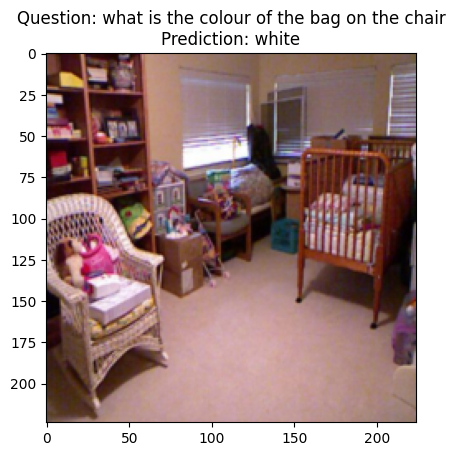

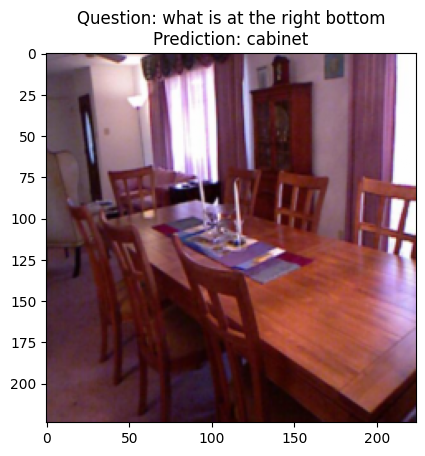

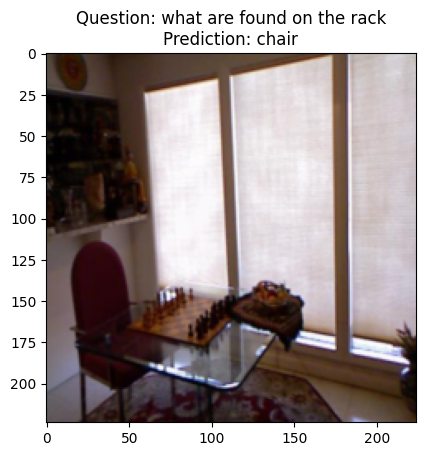

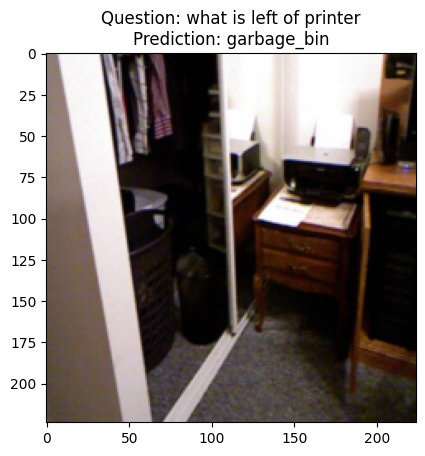

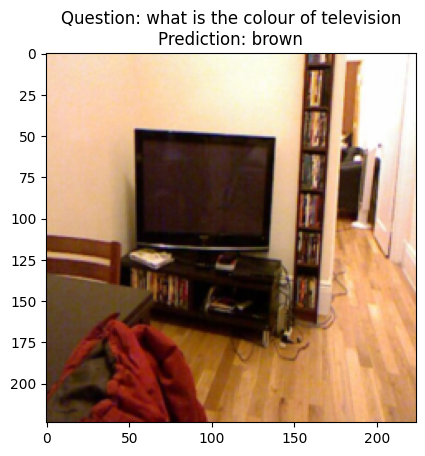

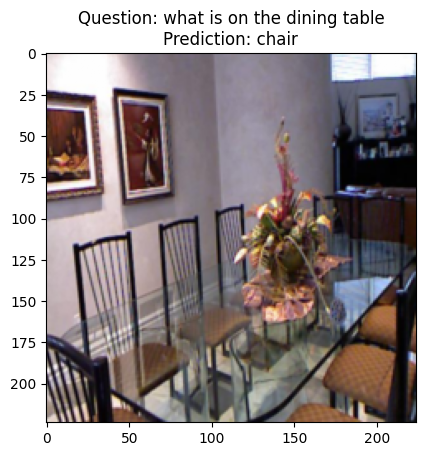

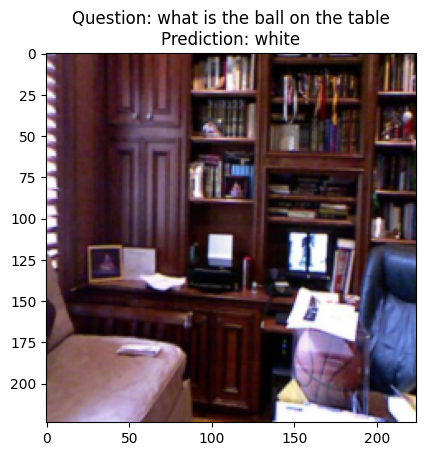

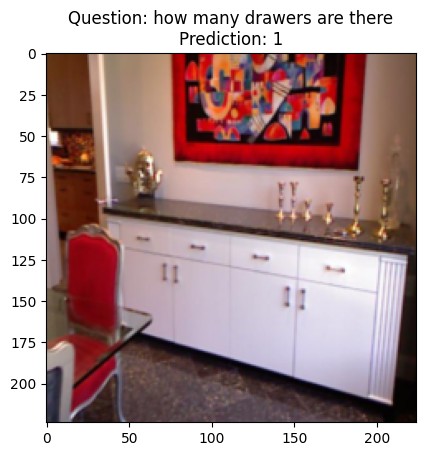

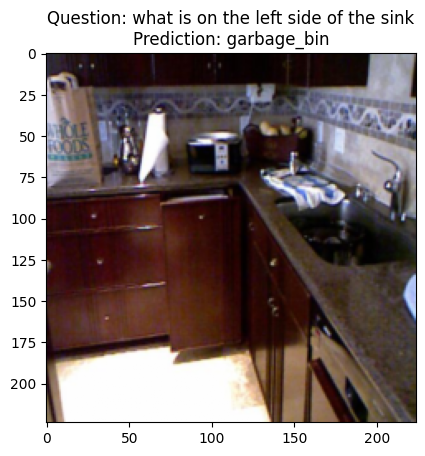

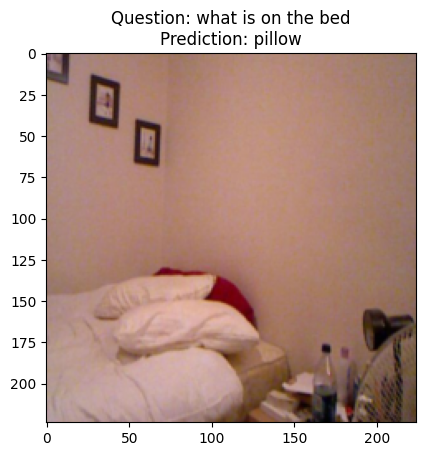

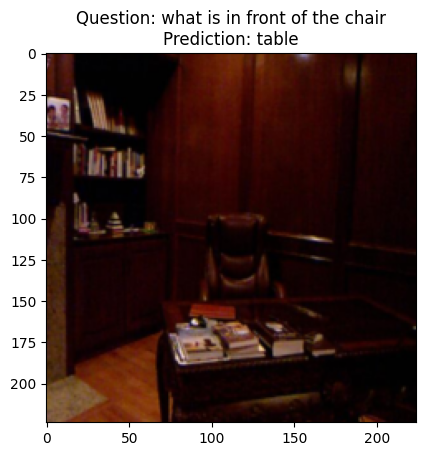

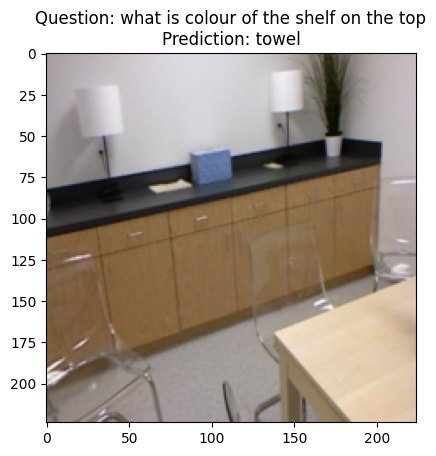

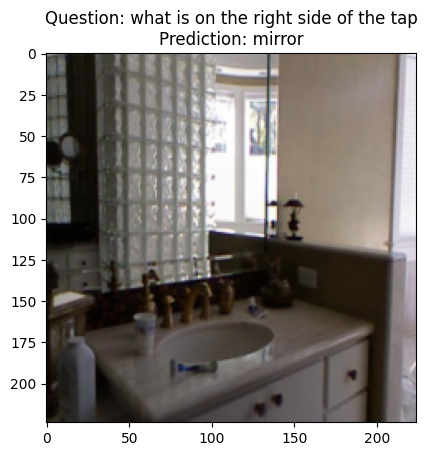

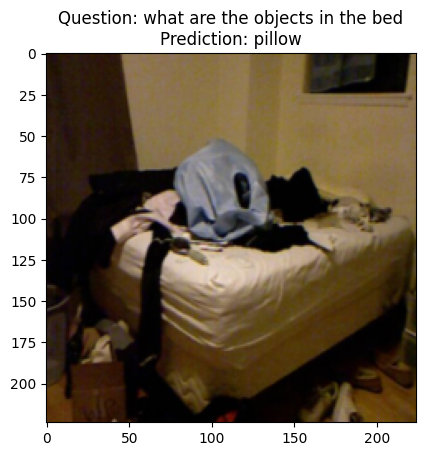

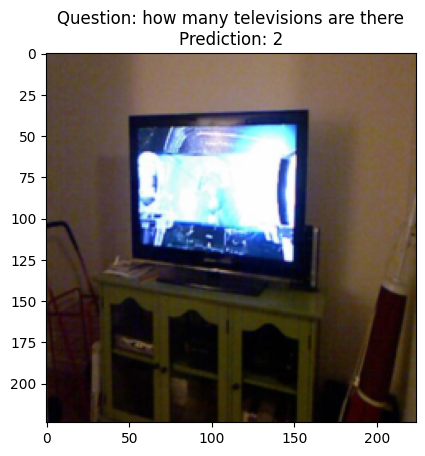

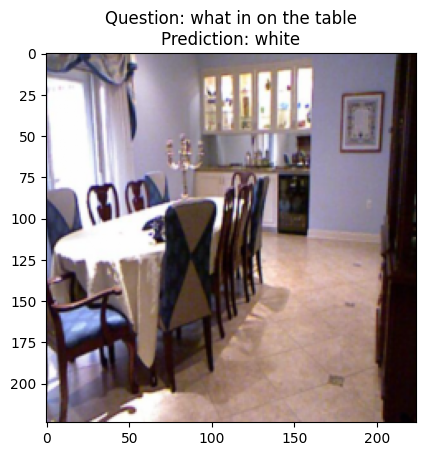

In [43]:
images, questions, labels, imgcap = next(iter(test_loader_visual))
question_list = [test_data[i]['question'] for i in range(len(test_data))]

images = images.to(device)
questions = questions.to(device)

model.eval()

with torch.no_grad():
    outputs = model(images, questions, None)
    _, preds = torch.max(outputs, 1)

for i in range(16):
    img = images[i].cpu().numpy().transpose(1, 2, 0) 
    
    plt.imshow(img)
    plt.title(f"Question: {question_list[i]}\nPrediction: {idx_to_classes[preds[i].item()]}")
    plt.show()


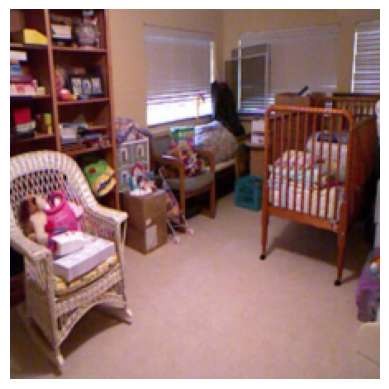

In [44]:
image_idx = 0  # Change this index to select a different image

# Get the image
img = images[image_idx].cpu().numpy().transpose(1, 2, 0)

# Display the image
plt.imshow(img)
plt.axis('off')  # Optionally remove axis
plt.show()

In [48]:
def preprocess_image(image_path):
    # Define the standard image transformations (resize, normalize, etc.)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to 224x224 pixels (standard size for many models like ResNet)
        transforms.ToTensor(),  # Convert image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats
    ])
    
    # Open the image using PIL
    image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
    
    # Apply transformations to the image
    image = transform(image)
    
    # Add a batch dimension since the model expects a batch of images
    image = image.unsqueeze(0)  # Shape: (1, 3, 224, 224)
    
    return image

In [50]:
def decode_output(output):
    # Assuming the model outputs a class index, you may want to map it to a human-readable class name
    predicted_class = output.item()  # Getting the predicted class index (for classification)
    return idx_to_classes.get(predicted_class, "Unknown")

In [55]:
image_path = 'dataset/images/image14.png'
question = 'What do you see in the image?'

# Preprocess the image and tokenize the question
image = preprocess_image(image_path)  # Preprocess image
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
question_tokens = tokenizer(question, return_tensors='pt')

In [56]:
model.eval()

# Make the prediction without calculating gradients
with torch.no_grad():
    # Pass image and question tokens to the model
    output = model(image.to(device), question_tokens['input_ids'].to(device), None)

    # Process the output, for example using the predicted class
    _, predicted_class = torch.max(output, dim=1)

    # Decode the prediction
    answer = decode_output(predicted_class)

# Print the result
print(f"Answer: {answer}")

Answer: sofa
